# Model Training

### Setup

In [1806]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from mahalanobis_distence_method import MahalanobisDistenceMethod

In [1786]:
def precision_recall_f1(cm):
    tn = cm[0][0]
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0
    recall = tp / (tp + fn) if tp + fn != 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0
    
    return (precision, recall, f1)

def accuracies(cm):
    tn = cm[0][0]
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    postive_acc = tp / (tp + fn)
    negative_acc = tn / (tn + fp)
    
    return (acc, postive_acc, negative_acc)

def intersection_threhold(results):
    for s_acc, l_acc, eps in zip(results["scam_accuracy"], results["legit_accuracy"], results["epsilon"]):
        if s_acc >= l_acc:
            return eps
    return 0

def feature_selection(ModelClass, X, y, feature_names, threshold_func):
    X = X.copy()
    y = y.copy()
    feature_names = feature_names.copy()
    
    selection = []
    for _ in tqdm(range(len(feature_names)-1)):
        accs = []
        for i in range(len(feature_names)):
            X_next = np.delete(X, i, axis=1)
            model = ModelClass(epsilon=0.03)
            model.fit(X_next)
            results = model.evaluate(X_next, y_train)
            
            eps = threshold_func(results)
            model.set_epsilon(eps)

            y_pred = model.classify(X_next)
            y_scam = y_pred[np.where(y==1)]
            y_legit = y_pred[np.where(y==0)]

            acc = np.sum(y_pred == y) / len(y_train)
            scam_acc = np.sum(y_scam == y[np.where(y==1)]) / len(y_scam)
            legit_acc = np.sum(y_legit == y[np.where(y==0)]) / len(y_legit)

            accs.append((i, acc))
        
        accs = sorted(accs, key=lambda a: a[1])
        idx, acc = accs[-1]
        X = np.delete(X, idx, axis=1)
        feature_names.pop(idx)
        selection.append((feature_names.copy(), acc))
    
    return selection

### Read and Split Data

In [1787]:
transaction_df = pd.read_csv("data/transactions.csv")

In [1788]:
train_df, test_df = train_test_split(transaction_df, train_size=0.8, shuffle=True, stratify=transaction_df["label"], random_state=1234)

In [1789]:
# Only keep nessesary features. 
train_df = train_df[['address', 'label', 'from_benfords_second', 'in_gas_limit_avg', 'merged_benfords_second', 'to_benfords_second']]
test_df = test_df[['address', 'label', 'from_benfords_second', 'in_gas_limit_avg', 'merged_benfords_second', 'to_benfords_second']]

In [1790]:
train_df.columns.tolist()

['address',
 'label',
 'from_benfords_second',
 'in_gas_limit_avg',
 'merged_benfords_second',
 'to_benfords_second']

### Data Exploration

In [1791]:
legit_df = train_df[train_df["label"] == 0].drop(columns=["label"])
scam_df = train_df[train_df["label"] == 1].drop(columns=["label"])

In [1792]:
legit_df.describe()

,from_benfords_second,in_gas_limit_avg,merged_benfords_second,to_benfords_second
count,748072.000000,7.480720e+05,748072.000000,748072.000000
mean,5.463394,1.027917e+05,12.260453,8.825854
std,7.043980,3.775520e+05,4.856137,6.952743
min,0.000000,0.000000e+00,0.000817,0.000000
25%,0.000000,0.000000e+00,9.858199,0.000000
50%,0.000000,0.000000e+00,14.906047,14.842111
75%,14.906047,6.300000e+04,15.033049,14.990842
max,15.117092,1.795264e+07,15.117092,15.117092


In [1793]:
scam_df.describe()

,from_benfords_second,in_gas_limit_avg,merged_benfords_second,to_benfords_second
count,4710.000000,4.710000e+03,4710.000000,4710.000000
mean,11.668948,4.425386e+05,14.432329,14.329737
std,5.908399,1.316225e+06,1.825883,2.196887
min,0.000000,0.000000e+00,0.005340,0.000000
25%,14.820733,5.582400e+04,14.820733,14.820733
50%,14.820733,1.750000e+05,14.820733,14.820733
75%,14.820733,2.000000e+05,14.884768,14.884768
max,15.117092,7.600027e+06,15.117092,15.117092


In [1794]:
trans_corr = train_df.corr()
legit_corr = legit_df.corr()
scam_corr = scam_df.corr()

abs_corr_dif = np.abs(legit_corr - scam_corr)

In [1795]:
sns.heatmap(trans_corr, xticklabels=True, yticklabels=True, square=True)
plt.title("Addresses Correltation Matrix")
plt.savefig("figures/add_corr_matrix.png")
plt.clf()

sns.heatmap(legit_corr, xticklabels=True, yticklabels=True, square=True)
plt.title("Legit Addresses Correltation Matrix")
plt.savefig("figures/leg_corr_matrix.png")
plt.clf()

sns.heatmap(scam_corr, xticklabels=True, yticklabels=True, square=True)
plt.title("Scam Addresses Correltation Matrix")
plt.savefig("figures/sca_corr_matrix.png")
plt.clf()

sns.heatmap(abs_corr_dif, xticklabels=True, yticklabels=True, square=True)
plt.title("Absolute Difference of Scam and Legit Correltation Matrices")
plt.savefig("figures/ad_corr_matrix.png")
plt.clf()

<Figure size 432x288 with 0 Axes>

### Feature Selection

In [1774]:
fs_results = feature_selection(MahalanobisDistenceMethod, X_train, y_train, feature_list, intersection_threhold)

  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: 'str' object is not callable

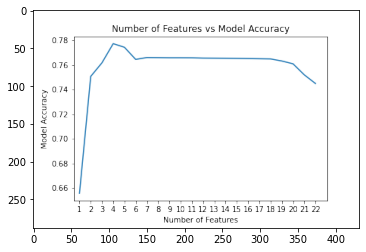

In [1807]:
accs = [acc for _, acc in reversed(fs_results)]
plt.plot(accs)
plt.xlabel("Number of Features")
plt.ylabel("Model Accuracy")
plt.title("Number of Features vs Model Accuracy")
plt.savefig("figures/feature_selection_plot.png")

In [1799]:
best_features = max(fs_results, key=lambda s: s[1])[0]
print("Features:", best_features)

Features: ['from_benfords_second', 'in_gas_limit_avg', 'merged_benfords_second', 'to_benfords_second']


In [1783]:
train_df = train_df[['address', 'label'] + best_features]
test_df = test_df[['address', 'label'] + best_features]

### Constructing Dataset and Centered and Scaled

In [1808]:
train_addr = train_proc_df["address"].to_numpy()
y_train = train_proc_df["label"].to_numpy()
X_train = train_proc_df.drop(columns=["address", "label"]).to_numpy()

test_addr = test_proc_df["address"].to_numpy()
y_test = test_proc_df["label"].to_numpy()
X_test = test_proc_df.drop(columns=["address", "label"]).to_numpy()

In [1809]:
ss = StandardScaler().fit(X_train)

In [1810]:
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### Train Model and Set Classification Threshold

In [1811]:
MDM = MahalanobisDistenceMethod()
MDM.fit(X_train)

In [1812]:
results = MDM.evaluate(X_train, y_train)

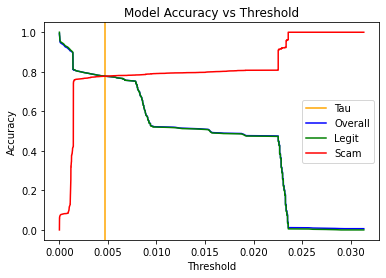

In [1813]:
eps = intersection_threhold(results)
MDM.set_epsilon(eps)
        
plt.axvline(eps, color="orange", label="Tau")
plt.plot(results["epsilon"], results["accuracy"], label="Overall", color="blue")
plt.plot(results["epsilon"], results["legit_accuracy"], label="Legit", color="green")
plt.plot(results["epsilon"], results["scam_accuracy"], label="Scam", color="red")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs Threshold")
plt.legend()
plt.savefig("figures/model_acc.png")

### Evaluate Training Set 

In [1814]:
y_pred = MDM.classify(X_train)

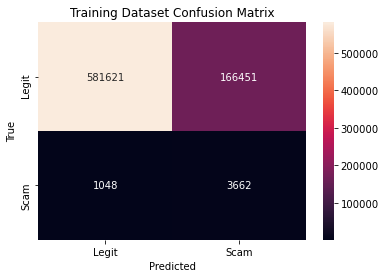

In [1815]:
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, xticklabels=["Legit", "Scam"], yticklabels=["Legit", "Scam"], fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Training Dataset Confusion Matrix")
plt.savefig("figures/train_conf.png")

In [1816]:
acc, scam_acc, legit_acc = accuracies(cm)
pre, rec, f1s = precision_recall_f1(cm)

In [1817]:
print(f"Precision: {pre:.3f} | Recall: {rec:.3f} | f1-score: {f1s:.3f}")
print(f"Training Accuracy: {acc*100:.2f}% | Legit Accuracy: {legit_acc*100:.2f}% | Scam Accuracy: {scam_acc*100:.2f}%")

Precision: 0.022 | Recall: 0.777 | f1-score: 0.042
Training Accuracy: 77.75% | Legit Accuracy: 77.75% | Scam Accuracy: 77.75%


### Evaluate Testing Set

In [1818]:
y_pred = MDM.classify(X_test)

In [1819]:
y_scam = y_pred[np.where(y_test==1)]
y_legit = y_pred[np.where(y_test==0)]

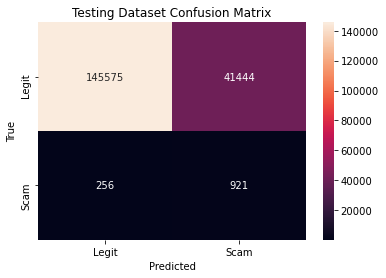

In [1820]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=["Legit", "Scam"], yticklabels=["Legit", "Scam"], fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Testing Dataset Confusion Matrix")
plt.savefig("figures/test_conf.png")

In [1821]:
acc, scam_acc, legit_acc = accuracies(cm)
pre, rec, f1s = precision_recall_f1(cm)

In [1822]:
print(f"Precision: {pre:.3f} | Recall: {rec:.3f} | f1-score: {f1s:.3f}")
print(f"Training Accuracy: {acc*100:.2f}% | Legit Accuracy: {legit_acc*100:.2f}% | Scam Accuracy: {scam_acc*100:.2f}%")

Precision: 0.022 | Recall: 0.782 | f1-score: 0.042
Training Accuracy: 77.84% | Legit Accuracy: 77.84% | Scam Accuracy: 78.25%


### Standard Scaling and Model Paraemters
Standard Scaling: $x_c = \frac{x-\mu}{\sigma}$

Multivariate Normal: $P(x; \mu, \sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}}e^{(-\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T)}$

In [1823]:
print("Standard Scalar Mean:", ss.mean_, end="\n")
print("Standard Scalar STD:", ss.scale_)

Standard Scalar Mean: [5.50222074e+00 1.04917419e+05 1.22740420e+01 8.86029064e+00]
Standard Scalar STD: [7.05442763e+00 3.91418459e+05 4.84609804e+00 6.94670091e+00]


In [1824]:
print(f"PDF Constent: {np.sqrt((2*np.pi)**X_train.shape[1] * np.linalg.det(sigma))**-1}")

PDF Constent: 0.039311655805354055


In [1825]:
print(f"PDF mu:", mu)

PDF mu: [ 8.98016104e-17  3.16674798e-17 -4.09647876e-17  6.55564026e-16]


In [1826]:
print(f"PDF sigma inv:\n{np.linalg.inv(sigma)}")

PDF sigma inv:
[[ 2.05904074 -0.48093814 -0.75351254  1.41395853]
 [-0.48093814  1.13400368  0.2042855  -0.19389946]
 [-0.75351254  0.2042855   1.42148603 -0.921056  ]
 [ 1.41395853 -0.19389946 -0.921056    2.13412928]]
